In [440]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import imblearn
import matplotlib.pyplot as plt

In [441]:
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [442]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR

## Data Understanding

In [443]:
df = pd.read_csv("loan.csv")

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

In [445]:
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [446]:
from ydata_profiling import ProfileReport

In [447]:
# pp = ProfileReport(df, title = "Exploration")

In [448]:
# pp.to_notebook_iframe()

## Data Selection
this was based on the correlation after data transformation, check on the markdown below

In [449]:
df = df[["AnnualIncome", "LoanAmount", "InterestRate", "MonthlyLoanPayment", "CreditScore", "NumberOfDependents", "LoanDuration", "EducationLevel", "Age", "EmploymentStatus", "MaritalStatus", "LoanApproved"]]

In [450]:
df_pipe = df.copy()
df_pipe_full = df.copy()

## Data Transformation

In [451]:
from sklearn import preprocessing

### Education

In [452]:
df["EducationLevel"]

0             Master
1          Associate
2           Bachelor
3        High School
4          Associate
            ...     
19995    High School
19996      Associate
19997       Bachelor
19998    High School
19999      Associate
Name: EducationLevel, Length: 20000, dtype: object

In [453]:
df["EducationLevel"] = pd.Categorical(df["EducationLevel"],categories =  ['High School', "Associate", "Bachelor", "Master", 'Doctorate'], ordered = True)

In [454]:
df["EducationLevel"]

0             Master
1          Associate
2           Bachelor
3        High School
4          Associate
            ...     
19995    High School
19996      Associate
19997       Bachelor
19998    High School
19999      Associate
Name: EducationLevel, Length: 20000, dtype: category
Categories (5, object): ['High School' < 'Associate' < 'Bachelor' < 'Master' < 'Doctorate']

In [455]:
label_education = preprocessing.LabelEncoder()

In [456]:
df["EducationLevel"] = label_education.fit_transform(df["EducationLevel"])

### Marital Status

In [457]:
# Sparse
df["MaritalStatus"].unique()

array(['Married', 'Single', 'Divorced', 'Widowed'], dtype=object)

In [458]:
df["MaritalStatus"] = pd.Categorical(df["MaritalStatus"], categories = ['Married', 'Single', 'Divorced', 'Widowed'])

In [459]:
categorical_marital = preprocessing.OneHotEncoder(sparse_output=False)

In [460]:
encoded_marital = categorical_marital.fit_transform(df[["MaritalStatus"]])
encoded_marital = pd.DataFrame(encoded_marital, columns=categorical_marital.get_feature_names_out(['MaritalStatus']))

In [461]:
encoded_marital

,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
19995,0.0,1.0,0.0,0.0
19996,0.0,1.0,0.0,0.0
19997,0.0,1.0,0.0,0.0
19998,0.0,1.0,0.0,0.0


In [462]:
df.drop("MaritalStatus", axis=1, inplace=True)
df = pd.concat([df, encoded_marital], axis=1)

### EmploymentStatus

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AnnualIncome            20000 non-null  int64  
 1   LoanAmount              20000 non-null  int64  
 2   InterestRate            20000 non-null  float64
 3   MonthlyLoanPayment      20000 non-null  float64
 4   CreditScore             20000 non-null  int64  
 5   NumberOfDependents      20000 non-null  int64  
 6   LoanDuration            20000 non-null  int64  
 7   EducationLevel          20000 non-null  int32  
 8   Age                     20000 non-null  int64  
 9   EmploymentStatus        20000 non-null  object 
 10  LoanApproved            20000 non-null  int64  
 11  MaritalStatus_Divorced  20000 non-null  float64
 12  MaritalStatus_Married   20000 non-null  float64
 13  MaritalStatus_Single    20000 non-null  float64
 14  MaritalStatus_Widowed   20000 non-null

In [464]:
# Sparse
df["EmploymentStatus"].unique()

array(['Employed', 'Self-Employed', 'Unemployed'], dtype=object)

In [465]:
df["EmploymentStatus"] = pd.Categorical(df["EmploymentStatus"], categories = ['Employed', 'Self-Employed', 'Unemployed'])

In [466]:
categorical_employment = preprocessing.OneHotEncoder(sparse_output=False)

In [467]:
encoded_employment = categorical_employment.fit_transform(df[["EmploymentStatus"]])
encoded_employment = pd.DataFrame(encoded_employment, columns=categorical_employment.get_feature_names_out(['EmploymentStatus']))

In [468]:
df.drop("EmploymentStatus", axis=1, inplace=True)
df = pd.concat([df, encoded_employment], axis=1)

In [469]:
df

,AnnualIncome,LoanAmount,InterestRate,MonthlyLoanPayment,CreditScore,NumberOfDependents,LoanDuration,EducationLevel,Age,LoanApproved,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed
0,39948,13152,0.227590,419.805992,617,2,48,4,45,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,39709,26045,0.201077,794.054238,628,1,48,0,38,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,40724,17627,0.212548,666.406688,570,2,36,1,47,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,69084,37898,0.300911,1047.506980,545,1,96,3,58,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,103264,9184,0.175990,330.179140,594,1,36,0,37,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,30180,24521,0.195574,905.767712,587,3,36,3,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19996,49246,25818,0.199168,958.395633,567,5,36,0,56,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19997,48958,37033,0.226766,945.427454,645,3,72,1,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19998,41025,14760,0.264873,411.168284,560,3,72,3,60,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## EDA

In [470]:
import plotly.express as px

# Calculate correlation matrix
corr_matrix = round(df.corr(numeric_only= True, method="spearman"), 2)

# Create a Plotly heatmap
fig = px.imshow(corr_matrix,
                text_auto=True,   # Annotates the heatmap with correlation values
                aspect="auto",    # Aspect ratio
                color_continuous_scale="Viridis", # Color scale
                width=800,        # Width of the plot
                height=600        # Height of the plot
               )

# Show the plot
fig.show()


In [471]:
df.corr(numeric_only= True, method="spearman")["LoanApproved"][abs(df.corr(numeric_only= True, method="spearman")["LoanApproved"])>0.2]

AnnualIncome          0.566892
LoanAmount           -0.260152
InterestRate         -0.307956
MonthlyLoanPayment   -0.222174
LoanApproved          1.000000
Name: LoanApproved, dtype: float64

In [472]:
abs(df.corr(numeric_only= True, method="spearman")["LoanApproved"])

AnnualIncome                      0.566892
LoanAmount                        0.260152
InterestRate                      0.307956
MonthlyLoanPayment                0.222174
CreditScore                       0.142818
NumberOfDependents                0.000702
LoanDuration                      0.088465
EducationLevel                    0.029313
Age                               0.143402
LoanApproved                      1.000000
MaritalStatus_Divorced            0.005743
MaritalStatus_Married             0.001125
MaritalStatus_Single              0.000601
MaritalStatus_Widowed             0.007944
EmploymentStatus_Employed         0.005740
EmploymentStatus_Self-Employed    0.027026
EmploymentStatus_Unemployed       0.036616
Name: LoanApproved, dtype: float64

Temuan berdasarkan korelasi tinggi:
1. AnnualIncome
2. LoanAmount
3. InterestRate
4. MonthlyLoanPayment
5. CreditScore

Yang seharusnya dipakai juga:
1. NumberOfDependents (korelasi hampir 0)
2. LoanDuration (<0,1)
3. EducationLevel (<0,1)
4. EmploymentStatus
5. Age

## Feature Engineering

### Scaling loan amount and annual income to IDR

In [473]:
px.box(df["AnnualIncome"])

According to BPS (2023), median of salary in Indonesia is Rp2.500.000, which is 51,47 times the median of this study case. So for that, we will scale AnnualIncome, LoanAmount, and MonthlyLoanPayment with 51,47.

In [474]:
df["AnnualIncome"] = df["AnnualIncome"]*51.47
df["LoanAmount"] = df["LoanAmount"]*51.47
df["MonthlyLoanPayment"] = df["MonthlyLoanPayment"]*51.47

In [475]:
df

,AnnualIncome,LoanAmount,InterestRate,MonthlyLoanPayment,CreditScore,NumberOfDependents,LoanDuration,EducationLevel,Age,LoanApproved,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed
0,2056123.56,676933.44,0.227590,21607.414386,617,2,48,4,45,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2043822.23,1340536.15,0.201077,40869.971641,628,1,48,0,38,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2096064.28,907261.69,0.212548,34299.952215,570,2,36,1,47,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3555753.48,1950610.06,0.300911,53915.184272,545,1,96,3,58,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,5314998.08,472700.48,0.175990,16994.320361,594,1,36,0,37,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1553364.60,1262095.87,0.195574,46619.864151,587,3,36,3,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19996,2534691.62,1328852.46,0.199168,49328.623240,567,5,36,0,56,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19997,2519868.26,1906088.51,0.226766,48661.151058,645,3,72,1,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19998,2111556.75,759697.20,0.264873,21162.831588,560,3,72,3,60,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [476]:
scaler = preprocessing.RobustScaler()
df[["AnnualIncome", "LoanAmount", "MonthlyLoanPayment", "CreditScore"]] = scaler.fit_transform(df[["AnnualIncome", "LoanAmount", "MonthlyLoanPayment", "CreditScore"]])

In [477]:
df

,AnnualIncome,LoanAmount,InterestRate,MonthlyLoanPayment,CreditScore,NumberOfDependents,LoanDuration,EducationLevel,Age,LoanApproved,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed
0,-0.201770,-0.574214,0.227590,-0.498711,0.565217,2,48,4,45,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.207366,0.270675,0.201077,0.105884,0.724638,1,48,0,38,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.183602,-0.280963,0.212548,-0.100330,-0.115942,2,36,1,47,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.480380,1.047412,0.300911,0.515334,-0.478261,1,96,3,58,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.280624,-0.834240,0.175990,-0.643502,0.231884,1,36,0,37,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.430465,0.170806,0.195574,0.286356,0.130435,3,36,3,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19996,0.015921,0.255799,0.199168,0.371376,-0.159420,5,36,0,56,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19997,0.009178,0.990727,0.226766,0.350426,0.971014,3,72,1,44,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19998,-0.176555,-0.468840,0.264873,-0.512665,-0.260870,3,72,3,60,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Data Pipeline

In [478]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [479]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_pipe.drop("LoanApproved", axis=1), df_pipe["LoanApproved"], test_size=0.2)

In [480]:
preprocessor = ColumnTransformer(transformers=[
    ('education_level', preprocessing.OrdinalEncoder(categories=[['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']], dtype=int), ['EducationLevel']),
    ('marital_status', preprocessing.OneHotEncoder(sparse_output=False, categories=[['Married', 'Single', 'Divorced', 'Widowed']]), ['MaritalStatus']),
    ('employment_status', preprocessing.OneHotEncoder(sparse_output=False, categories=[['Employed', 'Self-Employed', 'Unemployed']]), ['EmploymentStatus']),
    ('num', preprocessing.RobustScaler(), ['AnnualIncome', 'LoanAmount', 'MonthlyLoanPayment', 'CreditScore'])
], remainder='passthrough')



In [481]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('education_level',
                                 OrdinalEncoder(categories=[['High School',
                                                             'Associate',
                                                             'Bachelor',
                                                             'Master',
                                                             'Doctorate']],
                                                dtype=<class 'int'>),
                                 ['EducationLevel']),
                                ('marital_status',
                                 OneHotEncoder(categories=[['Married', 'Single',
                                                            'Divorced',
                                                            'Widowed']],
                                               sparse_output=False),
                                 ['MaritalStatus']),
                                ('employment_status',
                                 OneHotEncoder(categories=[['Employed',
                                                            'Self-Employed',
                                                            'Unemployed']],
                                               sparse_output=False),
                                 ['EmploymentStatus']),
                                ('num', RobustScaler(),
                                 ['AnnualIncome', 'LoanAmount',
                                  'MonthlyLoanPayment', 'CreditScore'])])

In [482]:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [483]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.262066,0.443301,0.009333,0.855072,0.226760,4.0,72.0,45.0
1,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.109784,-0.081464,0.058218,1.217391,0.194917,3.0,36.0,44.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.992405,0.906985,0.506149,-0.855072,0.245507,2.0,60.0,44.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.238219,0.080219,0.092614,-0.072464,0.262989,3.0,48.0,29.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.214093,-0.413874,-0.353699,-0.739130,0.238817,4.0,48.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.542701,0.285813,0.061510,0.043478,0.245692,0.0,60.0,57.0
15996,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.334525,-0.952272,-0.866491,0.565217,0.185254,1.0,60.0,34.0
15997,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.382172,0.275392,0.103397,0.420290,0.197019,2.0,48.0,25.0
15998,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.637015,0.702571,0.434615,1.391304,0.201544,2.0,48.0,50.0


### Resampling

In [484]:
from imblearn import over_sampling

In [485]:
df_temp = pd.DataFrame(X_train).reset_index(drop=True)
df_temp = pd.concat([df_temp, pd.DataFrame(Y_train).reset_index(drop = True)], axis=1)

In [486]:
df_temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,LoanApproved
0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.262066,0.443301,0.009333,0.855072,0.226760,4.0,72.0,45.0,0
1,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.109784,-0.081464,0.058218,1.217391,0.194917,3.0,36.0,44.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.992405,0.906985,0.506149,-0.855072,0.245507,2.0,60.0,44.0,1
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.238219,0.080219,0.092614,-0.072464,0.262989,3.0,48.0,29.0,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.214093,-0.413874,-0.353699,-0.739130,0.238817,4.0,48.0,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.542701,0.285813,0.061510,0.043478,0.245692,0.0,60.0,57.0,1
15996,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.334525,-0.952272,-0.866491,0.565217,0.185254,1.0,60.0,34.0,1
15997,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.382172,0.275392,0.103397,0.420290,0.197019,2.0,48.0,25.0,0
15998,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.637015,0.702571,0.434615,1.391304,0.201544,2.0,48.0,50.0,0


In [487]:
fig = px.pie(Y_train, names="LoanApproved")
fig.show()

In [488]:
smote = over_sampling.SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [489]:
fig = px.pie(Y_train_resampled, names="LoanApproved")
fig.show()

## Modelling

### All Models

Training Random Forest...

Classification Report for Random Forest (Train):
              precision    recall  f1-score   support

Not Approved       1.00      1.00      1.00     12192
    Approved       1.00      1.00      1.00      3808

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000

Random Forest Train Accuracy: 0.9999

Classification Report for Random Forest (Test):
              precision    recall  f1-score   support

Not Approved       0.92      0.96      0.94      3028
    Approved       0.85      0.72      0.78       972

    accuracy                           0.90      4000
   macro avg       0.88      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000

Random Forest Test Accuracy: 0.9018


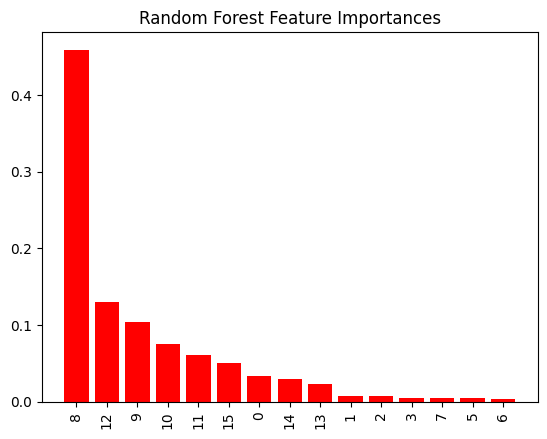

Training Ada Boost...


c:\Users\Asem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.




Classification Report for Ada Boost (Train):
              precision    recall  f1-score   support

Not Approved       0.93      0.95      0.94     12192
    Approved       0.83      0.76      0.79      3808

    accuracy                           0.91     16000
   macro avg       0.88      0.86      0.87     16000
weighted avg       0.90      0.91      0.90     16000

Ada Boost Train Accuracy: 0.9059

Classification Report for Ada Boost (Test):
              precision    recall  f1-score   support

Not Approved       0.92      0.95      0.94      3028
    Approved       0.84      0.76      0.79       972

    accuracy                           0.90      4000
   macro avg       0.88      0.85      0.87      4000
weighted avg       0.90      0.90      0.90      4000

Ada Boost Test Accuracy: 0.9045


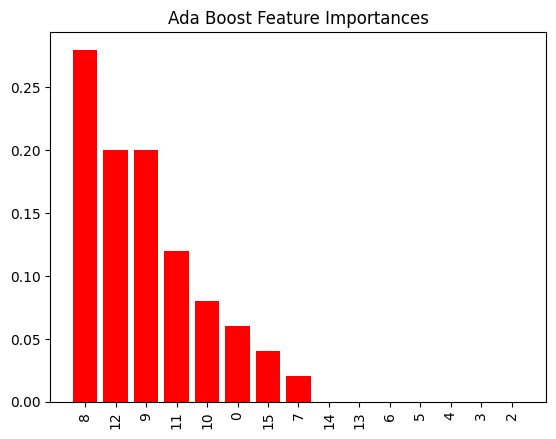

Training LightGBM...
[LightGBM] [Info] Number of positive: 3808, number of negative: 12192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238000 -> initscore=-1.163676
[LightGBM] [Info] Start training from score -1.163676

Classification Report for LightGBM (Train):
              precision    recall  f1-score   support

Not Approved       0.96      0.97      0.97     12192
    Approved       0.91      0.86      0.88      3808

    accuracy                           0.95     16000
   macro avg       0.93      0.92      0.93     16000
weighted avg       0.95      0.95      0.95     16000

LightGBM Train Accuracy: 0.9467

Classification Re

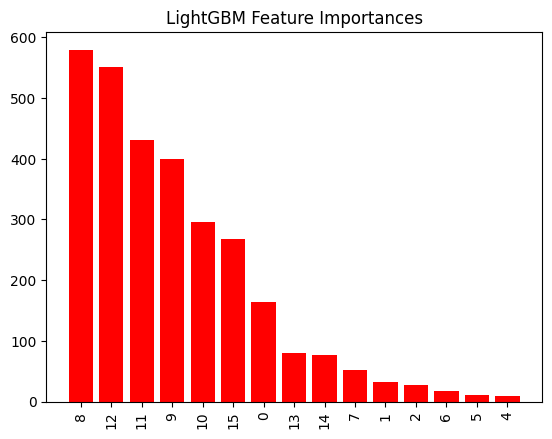

Training SVM...

Classification Report for SVM (Train):
              precision    recall  f1-score   support

Not Approved       0.84      0.99      0.91     12192
    Approved       0.94      0.37      0.53      3808

    accuracy                           0.85     16000
   macro avg       0.89      0.68      0.72     16000
weighted avg       0.86      0.85      0.82     16000

SVM Train Accuracy: 0.8451

Classification Report for SVM (Test):
              precision    recall  f1-score   support

Not Approved       0.83      0.99      0.90      3028
    Approved       0.95      0.37      0.53       972

    accuracy                           0.84      4000
   macro avg       0.89      0.68      0.72      4000
weighted avg       0.86      0.84      0.81      4000

SVM Test Accuracy: 0.8415
Training XGBoost...

Classification Report for XGBoost (Train):
              precision    recall  f1-score   support

Not Approved       0.98      0.99      0.98     12192
    Approved       0.96  

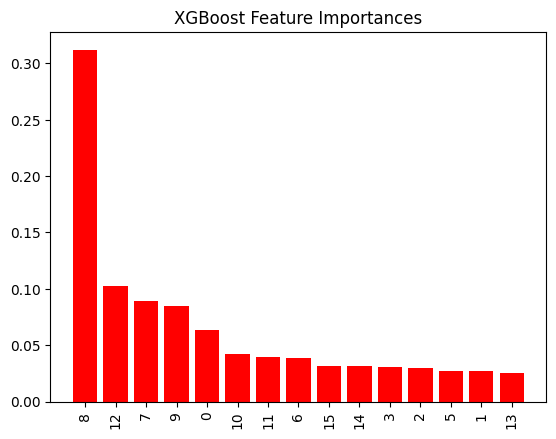

In [490]:
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Ada Boost': AdaBoostClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Initialize dictionary to store classification reports
classification_reports = {}
model_names = []
accuracies_train = []
accuracies_test = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, Y_train.values.ravel())

    # Predict on both training and test data
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Calculate confusion matrix and classification report for train data
    confusion_train = confusion_matrix(Y_train, Y_train_pred)
    classification_rep_train = classification_report(
        Y_train, Y_train_pred, target_names=['Not Approved', 'Approved'], zero_division=1
    )

    # Calculate confusion matrix and classification report for test data
    confusion_test = confusion_matrix(Y_test, Y_test_pred)
    classification_rep_test = classification_report(
        Y_test, Y_test_pred, target_names=['Not Approved', 'Approved'], zero_division=1
    )

    # Store the classification report in the dictionary for both train and test data
    classification_reports[model_name] = {
        'Train': classification_rep_train,
        'Test': classification_rep_test
    }

    # Calculate accuracy for train and test data
    accuracy_train = accuracy_score(Y_train, Y_train_pred)
    accuracy_test = accuracy_score(Y_test, Y_test_pred)

    # Store model names and accuracies
    model_names.append(model_name)
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

    # Print train classification report and accuracy
    print(f"\nClassification Report for {model_name} (Train):")
    print(classification_rep_train)
    print(f"{model_name} Train Accuracy: {accuracy_train:.4f}")
    print("=" * 50)

    # Print test classification report and accuracy
    print(f"\nClassification Report for {model_name} (Test):")
    print(classification_rep_test)
    print(f"{model_name} Test Accuracy: {accuracy_test:.4f}")
    print("=" * 50)

    # Feature importance (only for models that have feature_importances_)
    if hasattr(model, 'feature_importances_'):  # Check if model has feature_importances_
        features_importances = zip(model.feature_importances_, df_temp.drop("LoanApproved", axis=1).columns)
        sorted_feature_importances = sorted(features_importances, reverse=True)

        # Get top 15 predictors
        top_15_predictors = sorted_feature_importances[:15]
        values = [value for value, predictors in top_15_predictors]
        predictors = [predictors for value, predictors in top_15_predictors]

        # Plot the top 15 feature importances
        plt.figure()
        plt.title(f"{model_name} Feature Importances")
        plt.bar(range(len(predictors)), values, color="r", align="center")
        plt.xticks(range(len(predictors)), predictors, rotation=90)
        plt.show()


Based on the above, lets pick LGBM as the best model.


## Full Pipeline

In [432]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [431]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiplyByFactor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, factor=51.47):
        self.columns = columns
        self.factor = factor
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.columns is not None:
            X_copy[self.columns] *= self.factor
        return X_copy


In [433]:
preprocessor = ColumnTransformer(transformers=[
    ('multiply', MultiplyByFactor(columns=["AnnualIncome", "LoanAmount", "MonthlyLoanPayment"]), ["AnnualIncome", "LoanAmount", "MonthlyLoanPayment"]),
    ('education_level', preprocessing.OrdinalEncoder(categories=[['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']], dtype=int), ['EducationLevel']),
    ('marital_status', preprocessing.OneHotEncoder(sparse_output=False, categories=[['Married', 'Single', 'Divorced', 'Widowed']]), ['MaritalStatus']),
    ('employment_status', preprocessing.OneHotEncoder(sparse_output=False, categories=[['Employed', 'Self-Employed', 'Unemployed']]), ['EmploymentStatus']),
    ('num', preprocessing.RobustScaler(), ['AnnualIncome', 'LoanAmount', 'MonthlyLoanPayment', 'CreditScore'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

In [434]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_pipe_full.drop("LoanApproved", axis=1), df_pipe_full["LoanApproved"], test_size=0.2)

In [435]:
pipeline.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 3830, number of negative: 12170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239375 -> initscore=-1.156109
[LightGBM] [Info] Start training from score -1.156109


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('multiply',
                                                  MultiplyByFactor(columns=['AnnualIncome',
                                                                            'LoanAmount',
                                                                            'MonthlyLoanPayment']),
                                                  ['AnnualIncome', 'LoanAmount',
                                                   'MonthlyLoanPayment']),
                                                 ('education_level',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School',
                                                                              'Associate',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctorate']],
                                                                 dtype=<class '...
                                                  OneHotEncoder(categories=[['Married',
                                                                             'Single',
                                                                             'Divorced',
                                                                             'Widowed']],
                                                                sparse_output=False),
                                                  ['MaritalStatus']),
                                                 ('employment_status',
                                                  OneHotEncoder(categories=[['Employed',
                                                                             'Self-Employed',
                                                                             'Unemployed']],
                                                                sparse_output=False),
                                                  ['EmploymentStatus']),
                                                 ('num', RobustScaler(),
                                                  ['AnnualIncome', 'LoanAmount',
                                                   'MonthlyLoanPayment',
                                                   'CreditScore'])])),
                ('classifier', LGBMClassifier(random_state=42))])

In [438]:
# Fit the pipeline with training data
pipeline.fit(X_train, Y_train)

# Make predictions with the pipeline on X_test
Y_pred = pipeline.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

confusion = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", confusion)

classification_rep = classification_report(Y_test, Y_pred, target_names=['Not Approved', 'Approved'])
print("Classification Report:\n", classification_rep)

[LightGBM] [Info] Number of positive: 3830, number of negative: 12170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239375 -> initscore=-1.156109
[LightGBM] [Info] Start training from score -1.156109
Accuracy: 0.9075
Confusion Matrix:
 [[2899  151]
 [ 219  731]]
Classification Report:
               precision    recall  f1-score   support

Not Approved       0.93      0.95      0.94      3050
    Approved       0.83      0.77      0.80       950

    accuracy                           0.91      4000
   macro avg       0.88      0.86      0.87      4000
weighted avg       0.91      0.91      0.91      4000



### Export Model

In [439]:
# import joblib
# joblib.dump(pipeline, 'Credit Risk.pkl')

['Credit Risk.pkl']

## Experimentation
Try and temper with the RF

In [236]:
from sklearn import model_selection
from sklearn import metrics

In [235]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df.drop("LoanApproved", axis=1), df["LoanApproved"], test_size=0.2)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
confusion = confusion_matrix(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred, target_names=['Good', 'Bad'], zero_division=1)
    
metrics.classification_reports[model_name] = classification_rep

accuracy = accuracy_score(Y_test, Y_pred)

model_names.append(model_name)
accuracies.append(accuracy)

print("\nClassification Report:")
print(classification_rep)
print(f"{model_name} Accuracy: {accuracy:.4f}")
print("=" * 50)

In [237]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
confusion = confusion_matrix(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred, target_names=['Not Approved', 'Approved'], zero_division=1)

In [239]:
print(classification_rep)

              precision    recall  f1-score   support

Not Approved       0.92      0.95      0.94      3052
    Approved       0.83      0.72      0.77       948

    accuracy                           0.90      4000
   macro avg       0.87      0.84      0.85      4000
weighted avg       0.90      0.90      0.90      4000

